# Tutorial: Training Data Generation for RDL-SIM

## Overview
This notebook presents a comprehensive walkthrough of the training data generation process for image denoising with RDL-SIM . The approach focuses on generating paired datasets consisting of noisy inputs and corresponding high-SNR images derived from 3D raw microscope data.

## Objectives
- **Dataset Creation:** Develop pairs comprising noisy raw images and ground-truth images obtained with high signal-to-noise ratio (SNR).
- **Data Source:** Utilize the Microtubules dataset from BioSR for demonstration purposes. More details can be found at the [BioSR website](https://figshare.com/articles/dataset/BioSR/13264793).
- **Dataset Size:** For the demonstration, a small dataset with 5 patches per sample is generated. In practical scenarios, a larger dataset is recommended.
- **Tool Utilization:** Employ the CSBDeep library to streamline the data generation process. More information is available on the [CSBDeep documentation](https://csbdeep.bioimagecomputing.com/doc/).

## Steps
1. **Data Preparation:** Process the raw 3D noisy microscope data.
2. **Pair Generation:** Create paired samples, aligning noisy data with corresponding ground-truth high-SNR images.
3. **Data Augmentation:** Apply augmentation techniques to enhance dataset variability and robustness. (saves on disk)
4. **Analysis and Validation:** Assess the quality of generated pairs using visualization and statistical metrics.

## Conclusion
This structured guide details the procedures for generating training data essential for developing RDL-SIM denoising model, specillay prediction of high quality denoised images from noisy raw input data. 

In [1]:

import datetime
import os
from csbdeep.io import load_training_data
from csbdeep.utils import axes_dict, plot_some,plot_history
import matplotlib.pyplot as plt
# from models import DFCAN
from rdl_denoising.model_DFCAN import DFCAN
from rdl_denoising.loss_functions import mse_ssim, mse_ssim_psnr, mae_ssim
from rdl_denoising.data_gen import create_folders_DN, create_patches,RawData
from rdl_denoising.augmentation import flip_up_down, flip_left_right, transpose,  rotate_90, rotate_180, rotate_270

import numpy as np

from csbdeep.data.generate import norm_percentiles
from csbdeep.utils import normalize
import tifffile



2025-04-29 13:21:05.807957: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-29 13:21:06.012852: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-29 13:21:07.617841: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/student/a/asarker/.conda/envs/thesis/lib/:/home/student/a/asarker/.conda/envs/thesis/lib/python3.10/site-packages/nvidia/cudnn/lib:/home/student/a/asarker/.conda/envs/thesis/lib/:/home/student/a/asarker/.co

### Data Stracture

- Place your data inside the "dataset" folder. 
- Divide it into three separate folders: train, test, and validation. 
- Each folder should contain files organized by cell (e.g., Cell_xx → files).




### Create Validation Dataset
- we isolate training, testing and validation cells completely for make sure the data is unique. 
- Note: the number of patches are much smaller as we are creating a very small dataset for tutorial purpose only. 
- for real training, the number of patches needs to be much larger

In [2]:
definde_l = '04'

root_dir = '../dataset/microtubules/train'

create_folders_DN(root_dir, gt_filename="RawSIMData_gt",
    raw_filename=f"RawSIMData_level_{definde_l}")

# %%
patch_size_xy = 128
patch_size_z = 9
n_patches_per_image = 5

# %%
raw_data = RawData.from_folder (
    basepath    = f'{root_dir}/Train/DN',
    source_dirs = ['Raw'],
    target_dir  = 'GT',
    axes        = 'ZYX',
)


X, Y, XY_axes = create_patches (
    raw_data            = raw_data,
    patch_size          = (patch_size_z,patch_size_xy,patch_size_xy),
    n_patches_per_image = n_patches_per_image,
    save_file           = f'{root_dir}/Train/DN/microtubules_DN_trainig.npz',
    dfcan_data=True  # if TRUE:  generates data shape of n,H,W,C (eg. 100 , 128, 128, 9). FLASE: n,C,H,W
)

raw_folder_path = os.path.join(root_dir, 'Train', 'SR', 'Raw')
gt_folder_path = os.path.join(root_dir, 'Train', 'SR', 'GT')

# Count files in Raw and GT folders
files_Raw = os.listdir(raw_folder_path)
print(f"Number of files in Raw Folder: {len(files_Raw)}")

files_GT = os.listdir(gt_folder_path)
print(f"Number of files in GT Folder: {len(files_GT)}")

    5 raw images x    1 transformations   =     5 images
    5 images     x    5 patches per image =    25 patches in total
Input data:
../dataset/microtubules/train/Train/DN: target='GT', sources=['Raw'], axes='ZYX', pattern='*.tif*'
Transformations:
1 x Identity
128 x 128
Patch size:
9 x 128 x 128


100%|██████████| 5/5 [00:09<00:00,  1.88s/it]


Saving data to ../dataset/microtubules/train/Train/DN/microtubules_DN_trainig.npz.
Number of files in Raw Folder: 5
Number of files in GT Folder: 5


In [3]:
definde_l = '04'

root_dir_val = '../dataset/microtubules/val'

create_folders_DN(root_dir_val, gt_filename="RawSIMData_gt",
    raw_filename=f"RawSIMData_level_{definde_l}")

# %%
patch_size_xy = 128
patch_size_z = 9
n_patches_per_image = 5

# %%
raw_data = RawData.from_folder (
    basepath    = f'{root_dir_val}/Train/DN',
    source_dirs = ['Raw'],
    target_dir  = 'GT',
    axes        = 'ZYX',
)


X_val, Y_val, XY_axes_val = create_patches (
    raw_data            = raw_data,
    patch_size          = (patch_size_z,patch_size_xy,patch_size_xy),
    n_patches_per_image = n_patches_per_image,
    save_file           = f'{root_dir_val}/Train/DN/microtubules_DN_trainig.npz',
    dfcan_data=True # if TRUE:  generates data shape of n,H,W,C (eg. 100 , 128, 128, 9). FLASE: n,C,H,W
)



# Use os.path.join for path concatenation to avoid errors
raw_folder_path_val = os.path.join(root_dir_val, 'Train', 'SR', 'Raw')
gt_folder_path_val = os.path.join(root_dir_val, 'Train', 'SR', 'GT')

# Count files in Raw and GT folders
files_Raw_val = os.listdir(raw_folder_path_val)
print(f"Number of files in Raw Folder: {len(files_Raw_val)}")

files_GT_val= os.listdir(gt_folder_path_val)
print(f"Number of files in GT Folder: {len(files_GT_val)}")

    3 raw images x    1 transformations   =     3 images
    3 images     x    5 patches per image =    15 patches in total
Input data:
../dataset/microtubules/val/Train/DN: target='GT', sources=['Raw'], axes='ZYX', pattern='*.tif*'
Transformations:
1 x Identity
128 x 128
Patch size:
9 x 128 x 128


100%|██████████| 3/3 [00:06<00:00,  2.30s/it]

Saving data to ../dataset/microtubules/val/Train/DN/microtubules_DN_trainig.npz.
Number of files in Raw Folder: 3
Number of files in GT Folder: 3


In [4]:
print(' Information regarding training data')
print('----------------------------------')
print("shape of Input  Image  : X ", X.shape) 
print("shape of Ground Truth Image : Y ", Y.shape) 
print("axes  of X , Y ", XY_axes) 
print()
print('information regarding validation data')
print('----------------------------------')
print("shape of Input  Image  : X_val ", X_val.shape)
print("shape of Ground Truth Image : Y_val ", Y_val.shape)
print("axes  of X_val , Y_val ", XY_axes_val)

 Information regarding training data
----------------------------------
shape of Input  Image  : X  (25, 128, 128, 9)
shape of Ground Truth Image : Y  (25, 128, 128, 9)
axes  of X , Y  SYXC

information regarding validation data
----------------------------------
shape of Input  Image  : X_val  (15, 128, 128, 9)
shape of Ground Truth Image : Y_val  (15, 128, 128, 9)
axes  of X_val , Y_val  SYXC


### Visualization of Image Patches

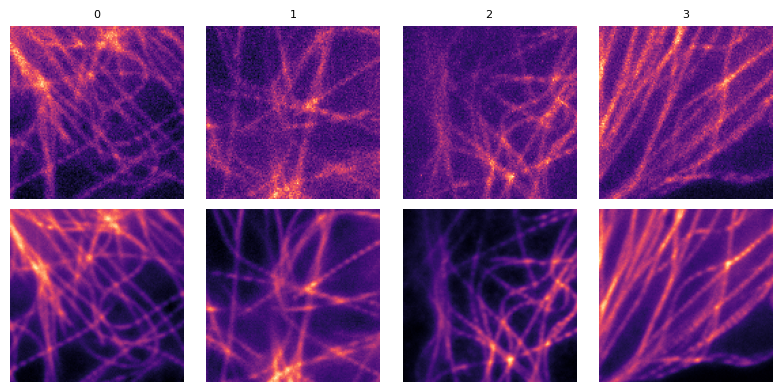

In [9]:
def plot_patches(X, Y, start_index=0, num_slice=4):
    sl = slice(start_index, start_index + num_slice)
    plt.figure(figsize=(8, 4))
    
    plot_some(X[sl][...,1], Y[sl][...,1], title_list=[np.arange(sl.start, sl.stop)])
    plt.tight_layout()
    plt.show()

plot_patches(X, Y, start_index=0, num_slice=4)

### Now we apply out augmentation fucntion on the generated data
received the data with dimensions H, W, C (e.g., 128 × 128 × 9) and outputs augmented data preserving the same dimensions (H, W, C).  
Note: The function integrates the following augmentations:  
- flip_up_down 
- flip_left_right  
- transpose  
- rotate_90  
- rotate_180  
- rotate_270 

In [5]:
def viz_aug(X, Y):
    """
    Visualizes the augmented image X and the ground truth Y.

    Parameters:
        X (numpy.ndarray): The augmented image array.
        Y (numpy.ndarray): The corresponding ground truth image array.
    """
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    #print(f'from visualizer : X {X.shape} {X.dtype}] : Y : {Y.shape} {Y.dtype} ')

    axes[0].imshow(X[...,1], cmap='viridis')
    axes[0].set_title('Augmented Image X')
    axes[0].axis('off')

    axes[1].imshow(Y, cmap='viridis')
    axes[1].set_title('Augmented Image Y')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()


def npz_info(file):
    """
    Displays information about the contents of a .npz file, including each array's shape and data type.

    Parameters:
        file (str): The file path to the .npz file.

    Returns:
        None. Prints the loaded file's arrays information.
    """
    npz_file = file

    try:
        data = np.load(npz_file)
    except IOError as e:
        print(f"Error loading .npz file: {e}")

    print(data)
    # Print the shape and dtype of each array in the .npz file
    for key in data.keys():
        print(f"{key} shape: {data[key].shape}, dtype: {data[key].dtype}")


def apply_augmentations_and_save(npz_file):
        try:
            data = np.load(npz_file)
        except IOError as e:
            print(f"Error loading .npz file: {e}")
            return
        
        if 'X' not in data or 'Y' not in data:
            print("Error: .npz file does not contain 'X' or 'Y' keys.")
            return
        #
        X = data['X']
        Y = data['Y']

        
        print(f"X shape before processing: {X.shape} {X.dtype}, Y shape before processing: {Y.shape} {Y.dtype}")

        augmented_X = []
        augmented_Y = []

        # augmentations = [
        #     ('flip_up_down', flip_up_down),
        #     ('flip_left_right', flip_left_right),
        #     ('transpose', transpose),
        #     ('rotate_90', rotate_90),
        #     ('rotate_180', rotate_180),
        #     ('rotate_270', rotate_270)
        # ]
        # augmentations = [flip_up_down, flip_left_right, transpose,  rotate_90, rotate_180, rotate_270]
        augmentations = [flip_up_down, flip_left_right,  rotate_90, rotate_180]
        for i in range(X.shape[0]):
            # print('just printing X', X.shape)
            ori_X = X[i]
            ori_Y = Y[i]
            # print(f'checking original image shapes :ori_X {ori_X.shape} : ori_Y {ori_Y.shape}')
            augmented_X.append(ori_X)
            augmented_Y.append(ori_Y)

            for aug_fn in augmentations:
                # print(f'this is aug_fun : {aug_fn} ' )
                # print(f' augmentation input , X : {X[i, 0].transpose(1, 2, 0).shape} , Y : {Y[i, 0].transpose(1, 2, 0).shape}') # augmentation input , X : (128, 128, 9) , Y : (256, 256, 1)
                aug_X, aug_Y = aug_fn(X[i], Y[i])
                
                # for vizualizing the augmentation
                #viz_aug(aug_X, aug_Y)

                #print(f'augmentation outoput: aug_X : {aug_X.shape} aug_Y : {aug_Y.shape} ') # augmentation outoput: aug_X : (128, 128, 9) aug_Y : (256, 256, 1) 
                # print(f'being added to the array :aug_X.transpose(2, 0, 1) {aug_X.transpose(2, 0, 1).shape} : aug_Y.transpose(2, 0, 1) {aug_Y.transpose(2, 0, 1).shape}') #being added to the array :aug_X.transpose(2, 0, 1) (9, 128, 128) : aug_Y.transpose(2, 0, 1) (1, 256, 256)
                augmented_X.append(aug_X)
                augmented_Y.append(aug_Y)

        augmented_X = np.array(augmented_X)
        augmented_Y = np.array(augmented_Y)
        print(f'Data comming out of the augmentation function: \naugmented_X : {augmented_X.shape} : augmented_Y:{augmented_Y.shape}') # augmented_X : (15300, 1, 9, 128, 128) : augmented_Y:(15300, 1, 1, 256, 256)
        directory_path = os.path.join(*npz_file.split('/')[:-1]) + '/'
        #print(f'directory_path : {directory_path}')#
        base_name = os.path.basename(npz_file)



        np.savez(directory_path + f'augmented_{base_name}', X=augmented_X, Y=augmented_Y, axes=data['axes'])
        print(f"Augmented data saved to augmented_{base_name}")
npz_file =  f'{root_dir}/Train/DN/microtubules_DN_trainig.npz'
apply_augmentations_and_save(npz_file)


X shape before processing: (25, 128, 128, 9) float32, Y shape before processing: (25, 128, 128, 9) float32
Data comming out of the augmentation function: 
augmented_X : (125, 128, 128, 9) : augmented_Y:(125, 128, 128, 9)
Augmented data saved to augmented_microtubules_DN_trainig.npz


In [6]:
npz_file =  f'{root_dir}/Train/DN/augmented_microtubules_DN_trainig.npz'
npz_info(npz_file)

NpzFile '../dataset/microtubules/train/Train/DN/augmented_microtubules_DN_trainig.npz' with keys: X, Y, axes
X shape: (125, 128, 128, 9), dtype: float32
Y shape: (125, 128, 128, 9), dtype: float32
axes shape: (), dtype: <U4


### Lets visualize the augmentations

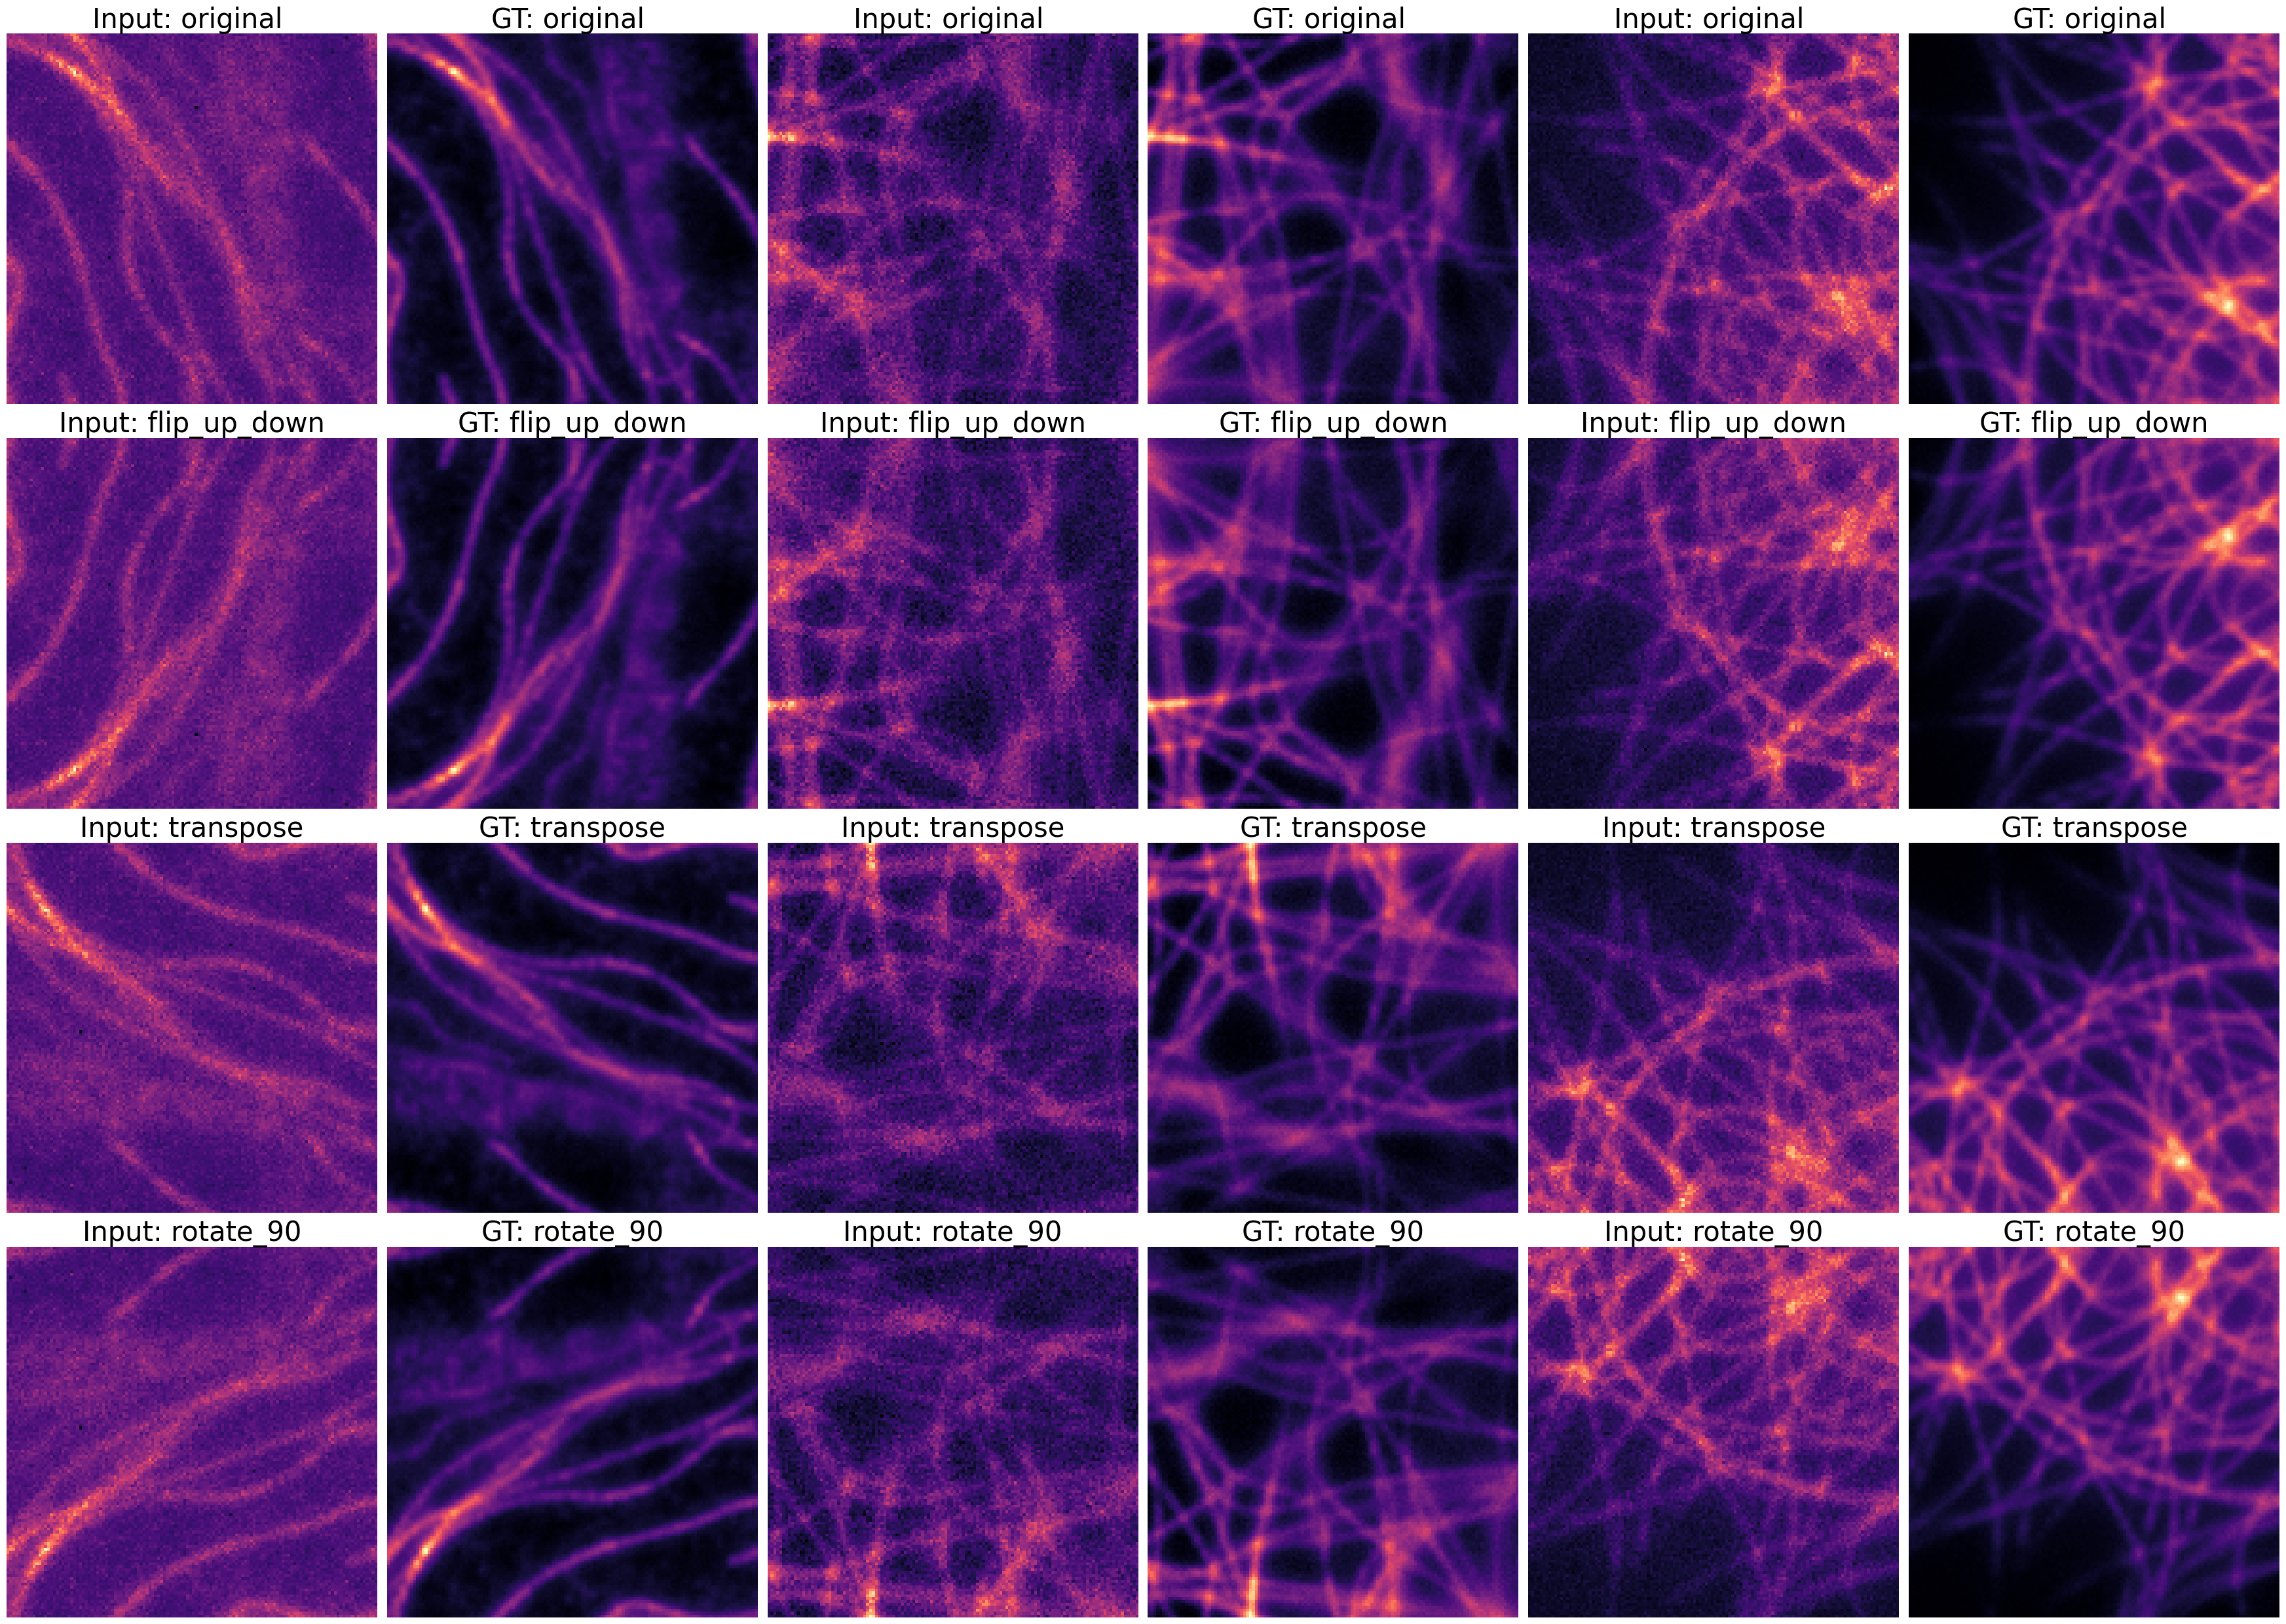

In [7]:
def visualize_XY_from_npz(npz_file, num_samples):
        """
        Visualize a subset of input and ground truth images from a .npz file containing keys 'X' and 'Y'.

        Parameters:
            npz_file (str): Path to the .npz file.
            num_samples (int): Number of samples to visualize.

        The function performs the following steps:
            - Loads the data from the .npz file.
            - Randomly selects a subset of data points.
            - Applies a sequence of augmentation functions to the images.
            - Displays both the original and augmented images in a grid for visual comparison.
        """



        try:
            data = np.load(npz_file)
        except IOError as e:
            print(f"Error loading .npz file: {e}")
            return
        
        if 'X' not in data or 'Y' not in data:
            print("Error: .npz file does not contain 'X' or 'Y' keys.")
            return
        
        X = data['X']
        Y = data['Y']
        # Randomly select 5 data points
        num_examples = num_samples
        indices = np.random.choice(X.shape[0], num_examples, replace=False)
        X = X[indices]
        Y = Y[indices]
        
        # augmentation functions
        augmentations = [
            ('flip_up_down', flip_up_down),
            # ('flip_left_right', flip_left_right),
            ('transpose', transpose),
            ('rotate_90', rotate_90),
            # ('rotate_180', rotate_180),
            # ('rotate_270', rotate_270)
        ]
        
        # Apply augmentations and visualize
        fig, axes = plt.subplots(len(augmentations) + 1, num_examples * 2, figsize=(35, 25)) # row, column, fig size
        
        for i in range(num_examples):
           
            # Display original images
            X_img = X[i]  # Get the first slice of the image as its a 9 channel image, only the 1st channel
            Y_img = Y[i] # Get the first slice of the image as its a 9 channel image
            # print(f'shape after changing dimension : X : { X_img.shape} : Y : {Y_img.shape} ')
            #output: shape after changing dimension : X : (128, 128) : Y : (256, 256)

            axes[0, i * 2].imshow(X_img[...,1], cmap='magma')
            axes[0, i * 2].set_title('Input: original ', fontsize=30)
            axes[0, i * 2].axis('off')

            axes[0, i * 2 + 1].imshow(Y_img[...,1], cmap='magma')
            axes[0, i * 2 + 1].set_title('GT: original ', fontsize=30)
            axes[0, i * 2 + 1].axis('off')
            

            for j, (aug_name, aug_fn) in enumerate(augmentations, start=1):
                aug_X, aug_Y = aug_fn(X_img, Y_img)
                
                axes[j, i * 2].imshow(aug_X[...,1], cmap='magma')
                axes[j, i * 2].set_title(f'Input: {aug_name}', fontsize=30)
                axes[j, i * 2].axis('off')

                axes[j, i * 2 + 1].imshow(aug_Y[...,1], cmap='magma')
                axes[j, i * 2 + 1].set_title(f'GT: {aug_name}', fontsize=30)
                axes[j, i * 2 + 1].axis('off')

        plt.tight_layout()
        plt.show()


# Example usage
npz_file =  f'{root_dir}/Train/DN/augmented_microtubules_DN_trainig.npz'
# Replace with your .npz file path
visualize_XY_from_npz( npz_file, 3)
